In [1]:
import os
print("yes "if "WANDB_API_KEY" in os.environ else "" )

# Flagellar Motor Detection in Bacteria Tomograms

In this notebook, we explore the dataset for detecting flagellar motors in bacterial tomograms.

**We will**:
- Set up our environment and reproducibility settings.
- Load and inspect the training labels.
- Examine key statistics including the distribution of motors per tomogram, tomogram sizes, and voxel spacing.
- Visualize sample tomogram slices to get a better feel for the data.
- 
**Let's begin!**
  
# 1) Library and dependecies

In [2]:
import os
local_dev =  "/workspace/BYU/notebooks" if "WANDB_API_KEY" in os.environ else "C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks"

yolo_dataset_dir = os.path.join(local_dev, 'yolo_dataset')
yolo_weights_dir = os.path.join(local_dev, 'yolo_weights')
yolo_inputs_dir = os.path.join("C:/Users/Freedomkwok2022/ML_Learn/BYU", 'input')

import plotly.express as px
from PIL import Image, ImageDraw
import random
import seaborn as sns
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import yaml
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor
import math

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Create the weights directory if it does not exist
os.makedirs(yolo_weights_dir, exist_ok=True)

output_location = "/kaggle/working"
output_location = local_dev


In [3]:
import cv2
import numpy as np
import random
from PIL import Image
from scipy.stats import entropy

def image_entropy(img_path):
    img = Image.open(img_path).convert("L")
    hist = img.histogram()
    hist = [float(h) / sum(hist) for h in hist if h != 0]
    return entropy(hist)

def is_low_info_image(image_path, threshold=50):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Cannot read: {image_path}")
    variance = cv2.Laplacian(image, cv2.CV_64F).var()
    return variance < threshold, variance

def is_static_noise_image(image_path, edge_thresh=60, hist_std_thresh=1000):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read: {image_path}")
    
    edges = cv2.Canny(img, 100, 200)
    edge_ratio = (edges > 0).sum() / edges.size * 100

    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    hist_std = np.std(hist)

    is_useless = edge_ratio > edge_thresh and hist_std > hist_std_thresh
    return is_useless, {"edge_ratio": edge_ratio, "hist_std": hist_std}

def is_useless_image(image_path, random_pass_chance=0):
    # Laplacian-based low-info check
    low_info, lap_score = is_low_info_image(image_path, threshold=50)
    
    # Entropy check
    ent_score = image_entropy(image_path)
    
    # Static noise check
    static_noise, static_info = is_static_noise_image(image_path)

    # Combine all criteria
    decision = low_info or ent_score > 7.0 or static_noise

    # Apply random pass override
    if decision and random.random() < random_pass_chance:
        decision = False
        static_info["random_pass_override"] = True
    else:
        static_info["random_pass_override"] = False

    return decision, {
        "low_info": low_info,
        "laplacian_var": lap_score,
        "entropy": ent_score,
        "static_noise": static_noise,
        "edge_ratio": static_info["edge_ratio"],
        "hist_std": static_info["hist_std"],
        "random_pass_override": static_info["random_pass_override"]
    }


In [4]:
yolo_dataset_dir

'C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\\yolo_dataset'

In [5]:
_image_name = 'images/BYU_cryoet2/train/aba2015-07-29-37_z0379_y0379_x0600_w0959_h0927_r0753.jpg'
_image_path = os.path.join(yolo_dataset_dir, _image_name)

is_useless_image(_image_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\\yolo_dataset\\images/BYU_cryoet2/train/aba2015-07-29-37_z0379_y0379_x0600_w0959_h0927_r0753.jpg'

In [230]:
_image_path = os.path.join(yolo_inputs_dir, 'BYU_cryoet2', 'train/mba2010-08-26-5/slice_0198.jpg')
is_useless_image(_image_path)

(False,
 {'low_info': False,
  'laplacian_var': 501.6222082460938,
  'entropy': 3.131402072263707,
  'static_noise': False,
  'edge_ratio': 0.050624999999999996,
  'hist_std': 2365.9993,
  'random_pass_override': False})

In [7]:
512*0.08

40.96

'400000'

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import shutil
# import time
import yaml
from pathlib import Path
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter/Kaggle environments

# Set random seed for reproducibility
np.random.seed(42)

# Define Kaggle paths
data_path = "../input/byu-locating-bacterial-flagellar-motors-2025/"
train_dir = os.path.join(data_path, "train")

yolo_dataset_dir = "./yolo_dataset/"

# Define constants
TRUST = 4  # Number of slices above and below center slice (total 2*TRUST + 1 slices)
BOX_SIZE = 30  # Bounding box size for annotations (in pixels)
TRAIN_SPLIT = 0.95  # 80% for training, 20% for validation
FIX_BOX_SIZE_RATIO = 0.075

# Image processing functions
def normalize_slice(slice_data):
    """
    Normalize slice data using 2nd and 98th percentiles
    """
    # Calculate percentiles
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)

    # Clip the data to the percentile range
    clipped_data = np.clip(slice_data, p2, p98)

    # Normalize to [0, 255] range
    normalized = 255 * (clipped_data - p2) / (p98 - p2)

    return np.uint8(normalized)

label_path = os.path.join(data_path, "labels.csv")

def prepare_yolo_dataset(prefix="", trust=TRUST, train_split=TRAIN_SPLIT, _label_path=label_path, _train_dir=train_dir):
    """
    Extract slices containing motors from tomograms and save to YOLO structure with annotations
    """
    if prefix == None or len(prefix) == 0:
        raise Exception("Something went wrong")
    
    yolo_images_train = os.path.join(yolo_dataset_dir, "images", prefix , "train")
    yolo_images_val = os.path.join(yolo_dataset_dir, "images", prefix, "val")
    yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", prefix, "train")
    yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", prefix, "val")

    # Create directories
    for dir_path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
        os.makedirs(dir_path, exist_ok=True)

    # Load the labels CSV
    labels_df = pd.read_csv(_label_path)

    # Count total number of motors
    
    if prefix.startswith('BYU'):
        total_motors = labels_df['Number of motors'].sum()
        print(f"Total number of motors in the dataset: {total_motors}")

    # Get unique tomograms that have motors
    tomo_df = labels_df[labels_df['Number of motors'] > 0].copy() if prefix.startswith('BYU') == 'BYU' else labels_df.copy()
    # tomo_df = tomo_df[:20]
    unique_tomos = tomo_df['tomo_id'].unique()

    print(f"Found {len(unique_tomos)} unique tomograms with motors || label {len(labels_df)}")

    # Perform the train-val split at the tomogram level (not motor level)
    # This ensures all slices from a single tomogram go to either train or val
    np.random.shuffle(unique_tomos)  # Shuffle the tomograms
    split_idx = int(len(unique_tomos) * train_split)
    train_tomos = unique_tomos[:split_idx]
    val_tomos = unique_tomos[split_idx:]
    missed_dict = dict()
    bad_images = dict()
    print(f"Split: {len(train_tomos)} tomograms for training, {len(val_tomos)} tomograms for validation")

    # Function to process a set of tomograms
    def process_tomogram_set(tomogram_ids, images_dir, labels_dir, set_name):
        motor_counts = []
        for tomo_id in tomogram_ids:
            # Get all motors for this tomogram
            tomo_motors = labels_df[labels_df['tomo_id'] == tomo_id]
            for _, motor in tomo_motors.iterrows():
                
                if prefix.startswith('BYU') and pd.isna(motor['Motor axis 0']):
                    continue
                
                _x = float(motor['Motor axis 2']) if prefix.startswith('BYU') else float(motor['x'])
                _y = float(motor['Motor axis 1']) if prefix.startswith('BYU') else float(motor['y'])
                if _x > 0.0 and _y >= 0.0:
                    motor_counts.append(
                        (
                            tomo_id,
                            int(motor['Motor axis 0']) if prefix.startswith('BYU') else int(motor['z']),
                            _y,
                            _x,
                            int(motor['Array shape (axis 0)']) if prefix.startswith('BYU') else 500
                        )
                    )
        
        print(f"Will process approximately {len(motor_counts) * (2 * trust + 1)} slices for {set_name} motor_counts: {len(motor_counts)} {type(motor_counts)}")

        # Process each motor
        processed_slices = 0
        outScale = 0
        for tomo_id, z_center, y_center, x_center, z_max in tqdm(motor_counts, desc=f"Processing {set_name} motors"):
            # Calculate range of slices to include
            z_min = max(0, z_center - trust)
            z_max = min(z_max - 1, z_center + trust)

            # Process each slice in the range
            for z in range(z_min, z_max + 1):
                # Create slice filename
                slice_filename = f"slice_{z:04d}.jpg"

                # Source path for the slice
                src_path = os.path.join(_train_dir, tomo_id, slice_filename)

                if not os.path.exists(src_path):
                    missed_dict[tomo_id] = 0
                    # print(f"Warning: {len(missed_dict)} {src_path} does not exist, skipping.")
                    continue
                
                if is_useless_image(src_path):
                    bad_images[tomo_id] = 0
                    
                # Load and normalize the slice
                img = Image.open(src_path)
                img_array = np.array(img)
                # Get image dimensions
                img_width, img_height = img.size
                if img_width <= 100 or img_width <= 100:
                    outScale += 1
                    continue
                
                # Normalize the image
                normalized_img = normalize_slice(img_array)

                box_size_ratio = round(FIX_BOX_SIZE_RATIO, 4) #round(np.random.uniform(0.07, 0.11), 4)
                box_size_tag = f"{int(box_size_ratio * 10000):04d}"
                
                # Create destination filename (with unique identifier)
                dest_filename = f"{tomo_id}_z{z:04d}_y{int(y_center):04d}_x{int(x_center):04d}_w{int(img_width):04d}_h{int(img_height):04d}_r{box_size_tag}.jpg"
                dest_path = os.path.join(images_dir, dest_filename)

                # Save the normalized image
                Image.fromarray(normalized_img).save(dest_path)

                
                # Create YOLO format label
                # YOLO format: <class> <x_center> <y_center> <width> <height>
                # Values are normalized to [0, 1]
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                # box_width_norm = BOX_SIZE / img_width
                # box_height_norm = BOX_SIZE / img_height
                box_width_norm = box_size_ratio
                box_height_norm = box_size_ratio
                
                # print(x_center, y_center, img_width, img_width, BOX_SIZE)
                # print(x_center_norm, y_center_norm, box_width_norm, box_height_norm, BOX_SIZE)

                # Write label file
                label_path = os.path.join(labels_dir, dest_filename.replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm} {y_center_norm} {box_width_norm} {box_height_norm}\n")

                processed_slices += 1
                
        print(f"Total OutScale {outScale}")
        print(f"Total bad_images {len(bad_images)}")
        return processed_slices, len(motor_counts)

    # Process training tomograms
    train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training")

    # Process validation tomograms
    val_slices, val_motors = process_tomogram_set(val_tomos, yolo_images_val, yolo_labels_val, "validation")

    print(f"\nProcessing Summary:")
    print(f"- Train set: {len(train_tomos)} tomograms, {train_motors} motors, {train_slices} slices")
    print(f"- Validation set: {len(val_tomos)} tomograms, {val_motors} motors, {val_slices} slices")
    print(
        f"- Total: {len(train_tomos) + len(val_tomos)} tomograms, {train_motors + val_motors} motors, {train_slices + val_slices} slices")

    # Return summary info
    return {
        "dataset_dir": yolo_dataset_dir,
        "yaml_path": os.path.join(yolo_dataset_dir, 'dataset.yaml'),
        "train_tomograms": len(train_tomos),
        "val_tomograms": len(val_tomos),
        "train_motors": train_motors,
        "val_motors": val_motors,
        "train_slices": train_slices,
        "val_slices": val_slices
    }

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os

def visualize_one_sample(img_path, label_path=None):
    """
    Visualize a single image with YOLO annotation overlay.

    Args:
        img_path (str): Path to the image file.
        label_path (str, optional): Path to the YOLO label (.txt) file. 
                                    If None, inferred from image path.
    """
    try:
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Normalize image for better contrast
        img_array = np.array(img)
        p2 = np.percentile(img_array, 2)
        p98 = np.percentile(img_array, 98)
        normalized = np.clip(img_array, p2, p98)
        normalized = 255 * (normalized - p2) / (p98 - p2)
        img_normalized = Image.fromarray(np.uint8(normalized)).convert('RGB')

        # Prepare overlay for annotations
        overlay = Image.new('RGBA', img_normalized.size, (0, 0, 0, 0))
        draw = ImageDraw.Draw(overlay)

        # Infer label path if not given
        if label_path is None:
            label_path = os.path.splitext(img_path.replace("images/train", "labels/train"))[0] + '.txt'

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * img_width
                    y_center = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height

                    annotations.append((class_id, x_center, y_center, width, height))

        for class_id, x_center, y_center, width, height in annotations:
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            draw.rectangle([x1, y1, x2, y2], fill=(255, 0, 0, 64), outline=(255, 0, 0, 200))
            draw.text((x1, y1 - 10), f"Class {class_id}", fill=(255, 0, 0, 255))

        if not annotations:
            draw.text((10, 10), "No annotations found", fill=(255, 0, 0, 255))

        final_img = Image.alpha_composite(img_normalized.convert('RGBA'), overlay).convert('RGB')

        # Show the image
        plt.figure(figsize=(8, 8))
        plt.imshow(np.array(final_img))
        plt.title(f"Image: {os.path.basename(img_path)} | Annotations: {len(annotations)}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

### byu-2025-cryoet-dataset-part-2 dataset ingest ###

In [6]:
import cv2
import numpy as np
import random

def is_static_noise_with_random_pass(image_path, edge_thresh=60, hist_std_thresh=1000, pass_chance=0.05):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read: {image_path}")

    edges = cv2.Canny(img, 100, 200)
    edge_ratio = (edges > 0).sum() / edges.size * 100

    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    hist_std = np.std(hist)

    is_useless = edge_ratio > edge_thresh and hist_std > hist_std_thresh

    # 5% chance to let it through even if it's considered useless
    if is_useless and random.random() < pass_chance:
        is_useless = False  # override decision

    return is_useless, {
        "edge_ratio": edge_ratio,
        "hist_std": hist_std,
        "random_pass": not is_useless and (edge_ratio > edge_thresh and hist_std > hist_std_thresh)
    }


row_id      tomo_id  Motor axis 0  Motor axis 1  Motor axis 2  \
0         0  tomo_003acc          -1.0          -1.0          -1.0   
10       10  tomo_0308c5          -1.0          -1.0          -1.0   
11       11  tomo_0333fa          -1.0          -1.0          -1.0   
15       15  tomo_040b80          -1.0          -1.0          -1.0   
16       16  tomo_049310          -1.0          -1.0          -1.0   
..      ...          ...           ...           ...           ...   
728     728  tomo_fc90fd          -1.0          -1.0          -1.0   
729     729  tomo_fd41c4          -1.0          -1.0          -1.0   
733     733  tomo_fe85f6          -1.0          -1.0          -1.0   
734     734  tomo_fea6e8          -1.0          -1.0          -1.0   
736     736  tomo_ff7c20          -1.0          -1.0          -1.0   

     Array shape (axis 0)  Array shape (axis 1)  Array shape (axis 2)  \
0                     500                  1912                  1847   
10                    300                   960                   928   
11                    300                   960                   928   
15                    600                   928                   960   
16                    500                   924                   956   
..                    ...                   ...                   ...   
728                   500                  1912                  1847   
729                   300                   928                   928   
733                   800                   928                   960   
734                   300                   960                   928   
736                   800                   928                   960   

     Voxel spacing  Number of motors  
0              6.5                 0  
10            15.6                 0  
11            16.8                 0  
15            16.1                 0  
16            19.7                 0  
..             ...               ...  
728            6.5                 0  
729           16.8                 0  
733           13.1                 0  
734           16.8                 0  
736           13.1                 0  

[286 rows x 10 columns]

In [6]:
import os
from pathlib import Path

# Define the path to your labels directory
label_dir = Path(yolo_dataset_dir +"/labels/shared/train")

# Loop through all .txt files
for label_file in label_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()

    needs_clear = False
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # Skip invalid lines
        _, x_center, y_center, _, _ = parts
        try:
            x = float(x_center)
            y = float(y_center)
            if x < 0 or y < 0:
                print(f"Invalid coords in: {label_file}")
                needs_clear = True
                break
        except ValueError:
            continue  # Skip malformed lines

    if needs_clear:
        with open(label_file, "w") as f:
            pass  # Overwrite with an empty file


In [ ]:
# tomo_counts = pd.read_csv('../input/cryoet-flagellar-motors-dataset/labels.csv')["tomo_id"].value_counts()

# # Filter those with count > 4a/
# filtered_ids = tomo_counts[tomo_counts > 4].index

In [ ]:
# tomo_df=pd.read_csv('../input/cryoet-flagellar-motors-dataset/labels.csv')
# tomo_df.groupby("tomo_id").value_counts
# tomo_df[tomo_df["tomo_id"].isin(filtered_ids)]

In [ ]:
# tomo_df=pd.read_csv('../input/cryoet-flagellar-motors-dataset/labels.csv')
# tomo_df[tomo_df["tomo_id"] == 'mba2012-03-09-23']

#### visualize_random_training_samples ####

In [9]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import subprocess  # to open files
import math

def visualize_random_training_samples(images_train_dir, labels_train_dir, num_samples=4, rows=2, original_dataset = None):
    """
    Visualize random training samples with YOLO annotations and clickable images.

    Args:
        images_train_dir (str): Directory containing training images
        labels_train_dir (str): Directory containing corresponding YOLO label .txt files
        num_samples (int): Number of random images to display
        rows (int): Number of rows in the output grid
    """

    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(images_train_dir, "**", ext), recursive=True))

    if len(image_files) == 0:
        print("No image files found!")
        return

    num_samples = min(num_samples, len(image_files))
    selected_images = random.sample(image_files, num_samples)

    cols = math.ceil(num_samples / rows)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(-1)  # flatten even if rows=1

    # Store which file each axis belongs to
    ax_to_file = {}
    img_paths = []  
    for i, (ax, img_path) in enumerate(zip(axes, selected_images)):
        try:
            relative_path = os.path.relpath(img_path, images_train_dir)
            label_path = os.path.join(labels_train_dir, os.path.splitext(relative_path)[0] + '.txt')

            img = Image.open(img_path)
            img_width, img_height = img.size
            img_paths.append(img_path)
            
            img_array = np.array(img)
            p2, p98 = np.percentile(img_array, 2), np.percentile(img_array, 98)
            normalized = np.clip(img_array, p2, p98)
            normalized = 255 * (normalized - p2) / (p98 - p2)
            img_normalized = Image.fromarray(np.uint8(normalized)).convert('RGB')

            overlay = Image.new('RGBA', img_normalized.size, (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)

            annotations = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        class_id, x_c, y_c, w, h = map(float, line.strip().split())
                        annotations.append({
                            'class_id': int(class_id),
                            'x_center': x_c * img_width,
                            'y_center': y_c * img_height,
                            'width': w * img_width,
                            'height': h * img_height,
                        })
                        
            if original_dataset:  
                newPath = label_path.replace(original_dataset[0], original_dataset[1])          
                if os.path.exists(path):
                    with open(newPath, 'r') as f:
                        for line in f:
                            class_id, x_c, y_c, w, h = map(float, line.strip().split())
                            annotations.append({
                                'class_id': int(class_id),
                                'x_center': x_c * img_width,
                                'y_center': y_c * img_height,
                                'width': w * img_width,
                                'height': h * img_height,
                                'origin': True
                            })
                            
            for ann in annotations:
                x1 = max(0, int(ann['x_center'] - ann['width']/2))
                y1 = max(0, int(ann['y_center'] - ann['height']/2))
                x2 = min(img_width, int(ann['x_center'] + ann['width']/2))
                y2 = min(img_height, int(ann['y_center'] + ann['height']/2))
                color = (0, 0, 255, 64) if ann.origin else (255, 0, 0, 64)
                draw.rectangle([x1, y1, x2, y2], fill=color, outline=(255, 0, 0, 255))
                draw.text((x1, y1-10), f"Class {ann['class_id']}", fill=(255, 0, 0, 255))               

            if not annotations:
                draw.text((10, 10), "No annotations found", fill=(255, 0, 0, 255))

            annotated_img = Image.alpha_composite(img_normalized.convert('RGBA'), overlay).convert('RGB')
            ax.imshow(annotated_img)
            ax.set_title(f"{os.path.basename(img_path)}\n({len(annotations)} annotations)", fontsize=9)
            ax.axis('off')
            ax_to_file[ax] = img_path

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            ax.axis('off')

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    # Connect click event to open in File Explorer
    plt.show()
    for i, path in enumerate(img_paths):
        print(f'{is_useless_image(path)}')
        print(os.path.join(local_dev, path))
        # print(f"{i:02d} " +  os.path.join(images_train_dir, path) + '\n')


### 1.1 Generate BYU Sample ###

In [28]:
prepare_yolo_dataset("BYU_007_100", train_split = 1)

Total number of motors in the dataset: 831
Found 648 unique tomograms with motors || label 737
Split: 648 tomograms for training, 0 tomograms for validation
Will process approximately 4059 slices for training motor_counts: 451 <class 'list'>


Processing training motors:   0%|          | 0/451 [00:00<?, ?it/s]

Total OutScale 0
Total bad_images 38
Will process approximately 0 slices for validation motor_counts: 0 <class 'list'>


Processing validation motors: 0it [00:00, ?it/s]

Total OutScale 0
Total bad_images 38

Processing Summary:
- Train set: 648 tomograms, 451 motors, 432 slices
- Validation set: 0 tomograms, 0 motors, 0 slices
- Total: 648 tomograms, 451 motors, 432 slices


{'dataset_dir': './yolo_dataset/',
 'yaml_path': './yolo_dataset/dataset.yaml',
 'train_tomograms': 648,
 'val_tomograms': 0,
 'train_motors': 451,
 'val_motors': 0,
 'train_slices': 432,
 'val_slices': 0}

In [31]:
summary = prepare_yolo_dataset(prefix = "cryoet_007" , _label_path = '../input/cryoet-flagellar-motors-dataset/labels.csv', _train_dir ='../input/cryoet-flagellar-motors-dataset/train')
print(f"\nPreprocessing Complete:")
print(
    f"- Training data: {summary['train_tomograms']} tomograms, {summary['train_motors']} motors, {summary['train_slices']} slices")
print(
    f"- Validation data: {summary['val_tomograms']} tomograms, {summary['val_motors']} motors, {summary['val_slices']} slices")
print(f"- Dataset directory: {summary['dataset_dir']}")
print(f"- YAML configuration: {summary['yaml_path']}")
print(f"\nReady for YOLO training!")

Found 1288 unique tomograms with motors || label 1617
Split: 1223 tomograms for training, 65 tomograms for validation
Will process approximately 13734 slices for training motor_counts: 1526 <class 'list'>


Processing training motors:   0%|          | 0/1526 [00:00<?, ?it/s]

Total OutScale 0
Total bad_images 1223
Will process approximately 819 slices for validation motor_counts: 91 <class 'list'>


Processing validation motors:   0%|          | 0/91 [00:00<?, ?it/s]

Total OutScale 0
Total bad_images 1288

Processing Summary:
- Train set: 1223 tomograms, 1526 motors, 13734 slices
- Validation set: 65 tomograms, 91 motors, 819 slices
- Total: 1288 tomograms, 1617 motors, 14553 slices

Preprocessing Complete:
- Training data: 1223 tomograms, 1526 motors, 13734 slices
- Validation data: 65 tomograms, 91 motors, 819 slices
- Dataset directory: ./yolo_dataset/
- YAML configuration: ./yolo_dataset/dataset.yaml

Ready for YOLO training!


In [30]:
summary = prepare_yolo_dataset(prefix = "BYU_cryoet2_007" , _label_path = '../input/BYU_cryoet2/labels.csv', _train_dir ='../input/BYU_cryoet2/train')

Total number of motors in the dataset: 2861
Found 1288 unique tomograms with motors || label 1617
Split: 1223 tomograms for training, 65 tomograms for validation
Will process approximately 13815 slices for training motor_counts: 1535 <class 'list'>


Processing training motors:   0%|          | 0/1535 [00:00<?, ?it/s]

Total OutScale 0
Total bad_images 412
Will process approximately 738 slices for validation motor_counts: 82 <class 'list'>


Processing validation motors:   0%|          | 0/82 [00:00<?, ?it/s]

Total OutScale 0
Total bad_images 440

Processing Summary:
- Train set: 1223 tomograms, 1535 motors, 4041 slices
- Validation set: 65 tomograms, 82 motors, 270 slices
- Total: 1288 tomograms, 1617 motors, 4311 slices


### 2.1 View Image ###

Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2012-03-09-1_z0084_y0175_x0345_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2011-08-01-18_z0049_y0217_x0195_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2011-02-16-35_z0054_y0236_x0256_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_aba2014-03-05-22_z0057_y0369_x0281_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_aba2015-07-15-3_z0062_y0439_x0181_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2011-07-31-6_z0071_y0219_x0194_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dat

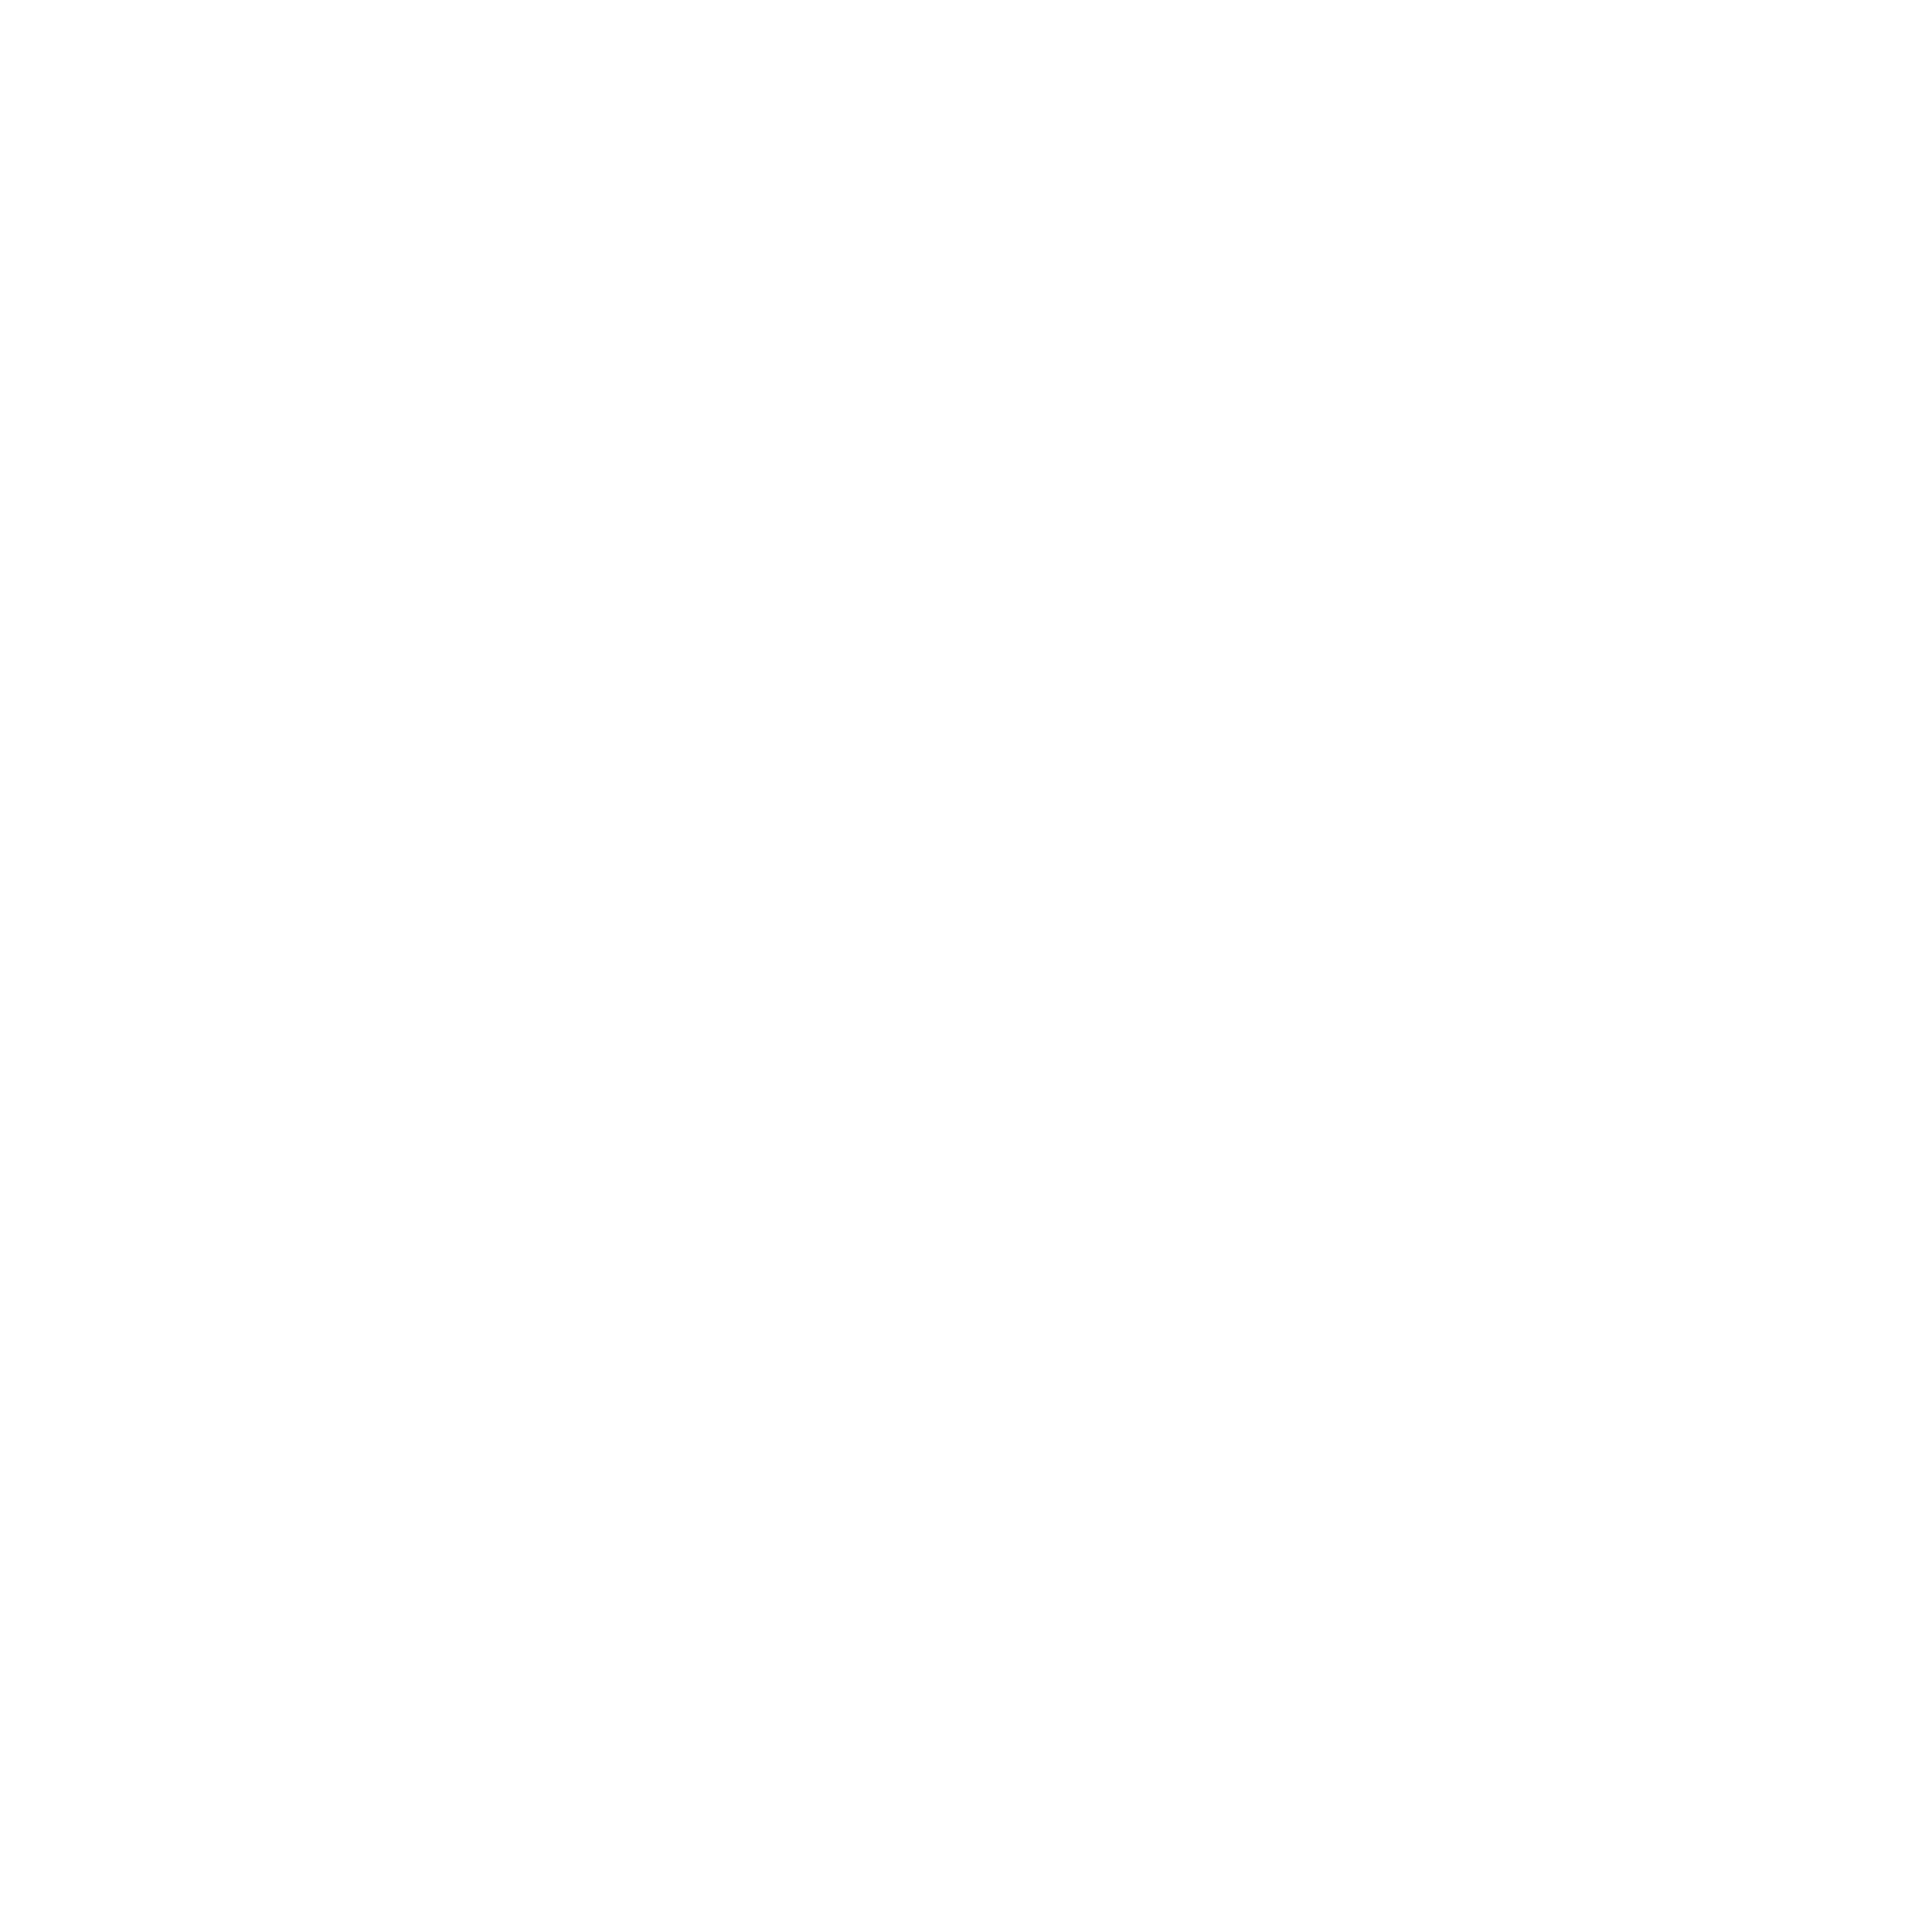

(False, {'low_info': False, 'laplacian_var': 3202.8965315208625, 'entropy': 5.430231683164127, 'static_noise': False, 'edge_ratio': 35.52513122558594, 'hist_std': 508.29193, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/train\cryoet_007_mba2012-03-09-1_z0084_y0175_x0345_w0512_h0512_r0750.jpg
(False, {'low_info': False, 'laplacian_var': 31790.23280358172, 'entropy': 5.397875294635721, 'static_noise': False, 'edge_ratio': 37.91923522949219, 'hist_std': 560.40936, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/train\cryoet_007_mba2011-08-01-18_z0049_y0217_x0195_w0512_h0512_r0750.jpg
(False, {'low_info': False, 'laplacian_var': 20426.56818284185, 'entropy': 5.374418287037889, 'static_noise': False, 'edge_ratio': 38.60015869140625, 'hist_std': 583.53094, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/

In [17]:
# # Run the visualization
byu_images_train_dir = "yolo_dataset/images/shared_007/train/"
byu_labels_train_dir = "yolo_dataset/labels/shared_007/train/"
visualize_random_training_samples(byu_images_train_dir, byu_labels_train_dir, 16, 4)

#### cryoet-flagellar-motors-dataset data sample ####

In [49]:
# # Run the visualization
_images_train_dir = "yolo_dataset/images/cryoet_007/train/"
_labels_train_dir = "yolo_dataset/labels/cryoet_007/train/"
visualize_random_training_samples(_images_train_dir, _labels_train_dir, 16, 4)

No image files found!


#### BYU_cryoet2 data sample ####

Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2012-02-02-7_z0052_y0395_x0295_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_aba2015-07-15-7_z0045_y0227_x0297_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2012-04-23-7_z0064_y0291_x0254_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_mba2011-02-16-37_z0068_y0239_x0233_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\BYU_007_100_tomo_101279_z0157_y0295_x0585_w0928_h0928_r0750.jpg: 'dict' object has no attribute 'origin'
Error processing yolo_dataset/images/shared_007/train\cryoet_007_aba2014-04-03-42_z0061_y0188_x0335_w0512_h0512_r0750.jpg: 'dict' object has no attribute 'origin'


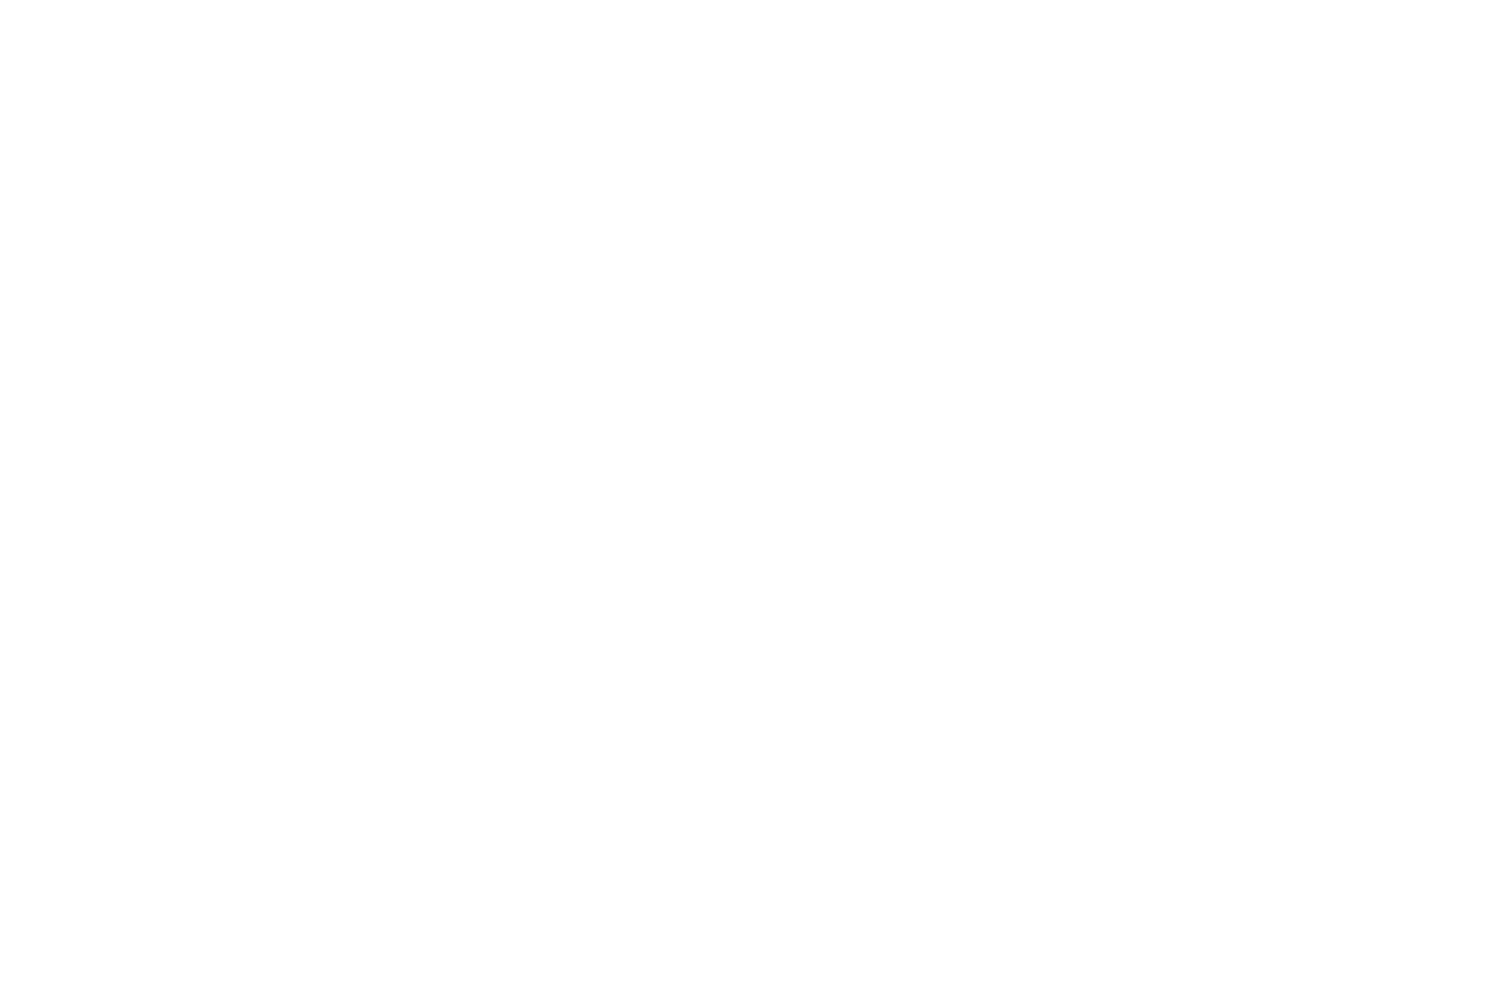

(False, {'low_info': False, 'laplacian_var': 25545.154570816012, 'entropy': 5.419501543760024, 'static_noise': False, 'edge_ratio': 38.00621032714844, 'hist_std': 529.93054, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/train\cryoet_007_mba2012-02-02-7_z0052_y0395_x0295_w0512_h0512_r0750.jpg
(False, {'low_info': False, 'laplacian_var': 80410.13230760998, 'entropy': 5.338099238129279, 'static_noise': False, 'edge_ratio': 32.01179504394531, 'hist_std': 660.35284, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/train\cryoet_007_aba2015-07-15-7_z0045_y0227_x0297_w0512_h0512_r0750.jpg
(False, {'low_info': False, 'laplacian_var': 489.2733960559126, 'entropy': 5.366704220825581, 'static_noise': False, 'edge_ratio': 25.926589965820312, 'hist_std': 614.84937, 'random_pass_override': False})
C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_dataset/images/shared_007/

In [15]:
# # Run the visualization
_images_train_dir = "yolo_dataset/images/shared_007/train/"
_labels_train_dir = "yolo_dataset/labels/shared_007/train/"
visualize_random_training_samples(_images_train_dir, _labels_train_dir, num_samples=6, rows=2)

In [7]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

## 1.1) Global Constants and Environment Setup

We define paths, create necessary directories, set up the computing device (GPU if available), and fix random seeds for reproducibility.


In [13]:
# Define global constants for dataset directories
DATA_DIR = '../input/byu-locating-bacterial-flagellar-motors-2025'
TRAIN_CSV = os.path.join(DATA_DIR, 'labels.csv')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
OUTPUT_DIR = './'
MODEL_DIR = './models'

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set device: Use GPU if available; otherwise, fall back to CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True


Using device: cuda


In [14]:
def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for training and validation, marking the best model.
    
    Args:
        run_dir (str): Directory where the training results are stored.
    """
    results_csv = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return
    
    results_df = pd.read_csv(results_csv)
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]
    
    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return
    
    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]
    
    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]
    
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--', 
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)
    plt.savefig(os.path.join(output_location, 'dfl_loss_curve.png'))
    
    print(f"Loss curve saved to {plot_path}")
    plt.close()
    
    return best_epoch, best_val_loss

In [120]:
pd.read_csv('../input/BYU_cryoet2/labels.csv')

row_id            tomo_id  Motor axis 0  Motor axis 1  Motor axis 2  \
0          0   mba2011-02-16-22    337.500000    643.195759    647.827815   
1          1   mba2011-02-16-22    337.500000    200.835728    354.851145   
2          2   mba2011-02-16-23    261.351562    298.371858    306.014735   
3          3   mba2011-02-16-21    281.250000    294.897826    292.118609   
4          4  mba2011-02-16-121    289.656250    284.475731    301.151091   
...      ...                ...           ...           ...           ...   
1612    1612   aba2015-07-15-65    293.750000    380.155546    340.712908   
1613    1613   aba2015-07-15-66    481.250000    421.051124    350.733157   
1614    1614   aba2015-07-15-67    337.500000    364.994298    424.831260   
1615    1615   aba2015-07-15-68    356.250000    361.880030    417.314061   
1616    1616   aba2015-07-15-69    537.500000    619.326192    615.982888   

      Array shape (axis 0)  Array shape (axis 1)  Array shape (axis 2)  \
0                      800                  1000                  1000   
1                      800                  1000                  1000   
2                      567                   600                   600   
3                      600                   600                   600   
4                      598                   600                   600   
...                    ...                   ...                   ...   
1612                   800                   927                   959   
1613                   800                   928                   960   
1614                   800                   928                   960   
1615                   800                   928                   960   
1616                   800                   928                   960   

      Voxel spacing  Number of motors  
0             5.120                 2  
1             5.120                 2  
2             5.120                 1  
3             5.120                 1  
4             5.120                 1  
...             ...               ...  
1612         13.059                 1  
1613         13.059                 1  
1614         13.059                 1  
1615         13.059                 1  
1616         13.059                 1  

[1617 rows x 10 columns]

## 3.8) Prepare Model Init

In [ ]:
import re

# def findMultipleLayerSample(model, val_dir, num_samples=4, conf:float=0.25):
#     # val_dir os.path.join(yolo_dataset_dir, 'images', 'val')
#     if not os.path.exists(val_dir):
#         print(f"Validation directory not found at {val_dir}")
#         val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
#         print(f"Using train directory for predictions instead: {val_dir}")
        
#     if not os.path.exists(val_dir):
#         print("No images directory found for predictions")
#         return
    
#     val_images = os.listdir(val_dir)
#     if len(val_images) == 0:
#         print("No images found for prediction")
#         return
    
#     num_samples = min(num_samples, len(val_images))
#     samples = random.sample(val_images, num_samples)
    
#     fig, axes = plt.subplots(2, 2, figsize=(12, 12))
#     axes = axes.flatten()
    
#     for i, img_file in enumerate(samples):
#         if i >= len(axes):
#             break
            
#         img_path = os.path.join(val_dir, img_file)
#         results = model.predict(img_path, conf=float(conf))[0]
#         img = Image.open(img_path)
#         axes[i].imshow(np.array(img), cmap='gray')
        
#         img_width, img_height = img.size
#         actual_box_size = img_width
#         # Draw ground truth box if available (extracted from filename)
        
        
        
    

#     # plt.savefig(os.path.join(output_location, 'predictions.png'))

    
#     return layer, path

# def display_iamges(iamges):
#     fig, axes = plt.subplots(2, 2, figsize=(12, 12))
#     axes = axes.flatten()
    
#     for i, img_file in enumerate(iamges):
#         if i >= len(axes):
#             break
#     try:
#         parts = img_file.split('_')
#         y_part = [p for p in parts if p.startswith('y')]
#         x_part = [p for p in parts if p.startswith('x')]
#         if y_part and x_part:
#             y_gt = int(y_part[0][1:])
#             x_gt = int(x_part[0][1:].split('.')[0])
#             rect_gt = Rectangle((x_gt - BOX_SIZE//2, y_gt - BOX_SIZE//2), BOX_SIZE, BOX_SIZE,
#                                     linewidth=1, edgecolor='g', facecolor='none')
#             axes[i].add_patch(rect_gt)
#     except:
#         pass
    
#     if len(results.boxes) > 0:
#             boxes = results.boxes.xyxy.cpu().numpy()
#             confs = results.boxes.conf.cpu().numpy()
#             for box, conf in zip(boxes, confs):
#                 x1, y1, x2, y2 = box
#                 rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
#                 axes[i].add_patch(rect_pred)
#                 axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')
        
#         axes[i].set_title(f"Image: {img_file}\nGT (green) vs Pred (red)")
    
    
def predict_on_samples(model, val_dir, num_samples=4, conf:float=0.25):
    # val_dir os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")
        
    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return
    
    val_images = os.listdir(val_dir)
    if len(val_images) == 0:
        print("No images found for prediction")
        return
    
    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break
            
        img_path = os.path.join(val_dir, img_file)
        results = model.predict(img_path, conf=float(conf))[0]
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')
        
        img_width, img_height = img.size
        actual_box_size = img_width
        # Draw ground truth box if available (extracted from filename)
        try:
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]
            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])
                rect_gt = Rectangle((x_gt - BOX_SIZE//2, y_gt - BOX_SIZE//2), BOX_SIZE, BOX_SIZE,
                                      linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass
        
        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')
        
        axes[i].set_title(f"Image: {img_file}\nGT (green) vs Pred (red)")
    
    plt.tight_layout()
    # plt.savefig(os.path.join(output_location, 'predictions.png'))
    plt.show()
    
def train_yolo_model(yaml_path, pretrained_weights_path, lr0 = 0.01, train=True, resume=False, epochs=30, batch_size=16, img_size=640, version="default"):
    """
    Train a YOLO model on the prepared dataset.
    
    Args:
        yaml_path (str): Path to the dataset YAML file.
        pretrained_weights_path (str): Path to pre-downloaded weights file.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        img_size (int): Image size for training.
    """
    # print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    model = YOLO(pretrained_weights_path)
    
    if train is False:
        return model, None
    
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        name=f'motor_detector_{version}',
        exist_ok=True,
        patience=5,
        save_period=5,
        val=True,
        verbose=True,
        resume=resume,
        lr0 = lr0
    )
    
    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')
    best_epoch_info = plot_dfl_loss_curve(run_dir)
    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")
    
    return model, results
    
def get_latest_model_version(base_dir, prefix="motor_detector"):
    max_version = -1
    best_path = None

    for name in os.listdir(base_dir):
        if name.startswith(prefix):
            match = re.search(rf"{prefix}.*?optuna_trial_(\d+)", name)  # works with 'v1' or '1'
            if match:
                version_num = int(match.group(1))
                candidate_path = os.path.join(base_dir, name, "weights", "best.pt")
                if os.path.exists(candidate_path) and version_num > max_version:
                    max_version = version_num
                    best_path = candidate_path

    return max_version, best_path

def get_best_model_for_dataset(dataset_name):
    json_path = os.path.join(yolo_weights_dir, "best_models.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            return json.load(f).get(dataset_name)
    return None

def save_best_model_info(dataset_name, best_trial, version, weights_path):
    json_path = os.path.join(yolo_weights_dir, "best_models.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            best_models = json.load(f)
    else:
        best_models = {}

    best_models[dataset_name] = {
        "version": version,
        "weights_path": weights_path,
        "val_loss": best_trial.value,
        "params": best_trial.params
    }

    with open(json_path, "w") as f:
        json.dump(best_models, f, indent=2)


def get_best_model_for_dataset(dataset_name):
    json_path = os.path.join(yolo_weights_dir, "best_models.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            return json.load(f).get(dataset_name)
    return None

# --- Enhanced pretrained model selector ---
def select_pretrained_weights(dataset_name):
    best_model_info = get_best_model_for_dataset(dataset_name)
    latest_version, latest_best_path = get_latest_model_version(yolo_weights_dir)
    print(latest_version, latest_best_path, yolo_weights_dir)
    
    if best_model_info and os.path.exists(best_model_info["weights_path"]):
        print(f"✅ Using best saved model for '{dataset_name}': {best_model_info['weights_path']}")
        return best_model_info["weights_path"]
    elif latest_best_path:
        print(f"🕓 No saved best model for '{dataset_name}'")
        print(f"latest available model: {latest_best_path}")
        return latest_best_path
    else:
        print("❌ No previous models found — using base weights: yolo11m.pt")
        return "yolo11m.pt"

In [26]:
select_pretrained_weights("shared")
yolo_weights_dir

42 C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights\motor_detector_shared_optuna_trial_42\weights\best.pt C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights
🕓 No saved best model for 'shared'
latest available model: C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights\motor_detector_shared_optuna_trial_42\weights\best.pt


'C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\\yolo_weights'

In [26]:
import os
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

def prepare_dataset(source):
    """
    Check if the dataset exists and create/fix a proper YAML file for training.
    
    Returns:
        str: Path to the YAML file to use for training.
    """
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', source, 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', source, 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', source, 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', source, 'val')
    
    # print(f"Directory status:")
    # print(f"- Train images exists: {os.path.exists(train_images_dir)}")
    # print(f"- Val images exists: {os.path.exists(val_images_dir)}")
    # print(f"- Train labels exists: {os.path.exists(train_labels_dir)}")
    # print(f"- Val labels exists: {os.path.exists(val_labels_dir)}")
    
    yaml_data = {
        'path': yolo_dataset_dir,
        'train': train_images_dir,
        'val': val_images_dir,
        'names': {0: 'motor'}
    }
    new_yaml_path = os.path.join(local_dev, 'dataset.yaml')
    with open(new_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)
    print(f"Created new YAML at {new_yaml_path}")
    print(yaml_data)
    
    return (new_yaml_path, train_images_dir, train_labels_dir, val_images_dir, val_labels_dir)

In [23]:
pretrained_weights_path = "yolo11m.pt"  # fallback default
output_location = yolo_weights_dir  # or any other preferred output dir

In [32]:
def objective(trial):
    lr0 = trial.suggest_float("lr0", 1e-5, 1e-1, log=True)
    batch = trial.suggest_categorical("batch", [8, 16, 32])
    imgsz = trial.suggest_categorical("imgsz", [416, 512, 640])
    hsv_h = trial.suggest_float("hsv_h", 0.0, 0.05)
    hsv_s = trial.suggest_float("hsv_s", 0.0, 1.0)
    hsv_v = trial.suggest_float("hsv_v", 0.0, 1.0)
    scale = trial.suggest_float("scale", 0.0, 0.9)
    flipud = trial.suggest_float("flipud", 0.0, 0.5)
    fliplr = trial.suggest_float("fliplr", 0.0, 1.0)
    bgr = trial.suggest_float("bgr", 0.0, 1.0)
    mixup = trial.suggest_float("mixup", 0.0, 1.0)

    version = f"optuna_trial_{trial.number}"
    run_dir = os.path.join(yolo_weights_dir, f"motor_detector_{version}")

    model = YOLO(pretrained_weights_path)
    model.train(
        data=yaml_path,
        epochs=30,
        imgsz=imgsz,
        batch=batch,
        lr0=lr0,
        project=yolo_weights_dir,
        name=f"motor_detector_{version}",
        exist_ok=True,
        patience=5,
        verbose=False,
        hsv_h=hsv_h,
        hsv_s=hsv_s,
        hsv_v=hsv_v,
        scale=scale,
        flipud=flipud,
        fliplr=fliplr,
        bgr=bgr,
        mixup=mixup
    )

    result = plot_dfl_loss_curve(run_dir)
    if result is None:
        return float("inf")

    best_epoch, best_val_loss = result
    print(f"Trial {trial.number}: Best Val DFL Loss = {best_val_loss:.4f} at Epoch {best_epoch}")
    return best_val_loss

def run_optuna_tuning():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)

    print("\n🎯 Best Trial:")
    print(f"  Value: {study.best_trial.value}")
    print(f"  Params: {study.best_trial.params}")

In [ ]:

# --- Main ---
def main():
    global yaml_path, pretrained_weights_path
    print("Starting YOLO Optuna parameter tuning...")
    
    # Step 1: Prepare new dataset (e.g. BYU or others)
    source = "BYU"  # <-- change this to another dataset when needed
    yaml_path, *_ = prepare_dataset(source)

    # Step 2: Attempt to load the best prior model
    latest_version, latest_best_path = get_latest_model_version(yolo_weights_dir)

    if latest_best_path:
        pretrained_weights_path = latest_best_path
        print(f"Found previous model at: {pretrained_weights_path}")
    else:
        pretrained_weights_path = "yolo11m.pt"
        print("No prior model found — using base weights: yolo11m.pt")

    # Step 3: Launch Optuna for tuning on the new dataset
    run_optuna_tuning()

if __name__ == "__main__":
    main()

In [ ]:
BYU_tomo_0a8f05_z0048_y0587_x0575.jpg
BYU_tomo_0a8f05_z0048_y0587_x0575

0 0.6196120689655172 0.6325431034482759 0.02693965517241379 0.02693965517241379


#### 3 Best Model Eval ####

In [31]:
yolo_dataset_dir

'./yolo_dataset/'

In [32]:
global val_images_dir 

# best_trial = "24"
# best_version = f"motor_detector_{dataset}_optuna_trial_{best_trial}"
# best_weights_path = os.path.join(yolo_weights_dir, best_version, "weights", "best.pt")

dataset = 'shared_007'
val_images_dir = os.path.join(yolo_dataset_dir, 'images', dataset, 'val')
best_weights_path = select_pretrained_weights(dataset)
model = YOLO(best_weights_path)
model.info()


42 C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights\motor_detector_shared_optuna_trial_42\weights\best.pt C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights
🕓 No saved best model for 'shared_007'
latest available model: C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights\motor_detector_shared_optuna_trial_42\weights\best.pt
YOLO11s summary: 181 layers, 9,428,179 parameters, 0 gradients, 21.5 GFLOPs


(181, 9428179, 0, 21.548492800000002)


image 1/1 c:\Users\Freedomkwok2022\ML_Learn\BYU\notebooks\yolo_dataset\images\shared_007\val\cryoet_007_mba2012-09-28-2_z0076_y0268_x0200_w0512_h0512_r0750.jpg: 512x512 2 motors, 4.4ms
Speed: 2.0ms preprocess, 4.4ms inference, 90.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 c:\Users\Freedomkwok2022\ML_Learn\BYU\notebooks\yolo_dataset\images\shared_007\val\cryoet_007_ycw2013-08-20-51_z0064_y0178_x0038_w0512_h0512_r0750.jpg: 512x512 1 motor, 4.1ms
Speed: 0.8ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 c:\Users\Freedomkwok2022\ML_Learn\BYU\notebooks\yolo_dataset\images\shared_007\val\cryoet_007_mba2011-02-16-43_z0061_y0271_x0254_w0512_h0512_r0750.jpg: 512x512 (no detections), 3.9ms
Speed: 0.8ms preprocess, 3.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 c:\Users\Freedomkwok2022\ML_Learn\BYU\notebooks\yolo_dataset\images\shared_007\val\BYU_cryoet2_007_mba2011-02-16-15_z0315_y1249_x0787_

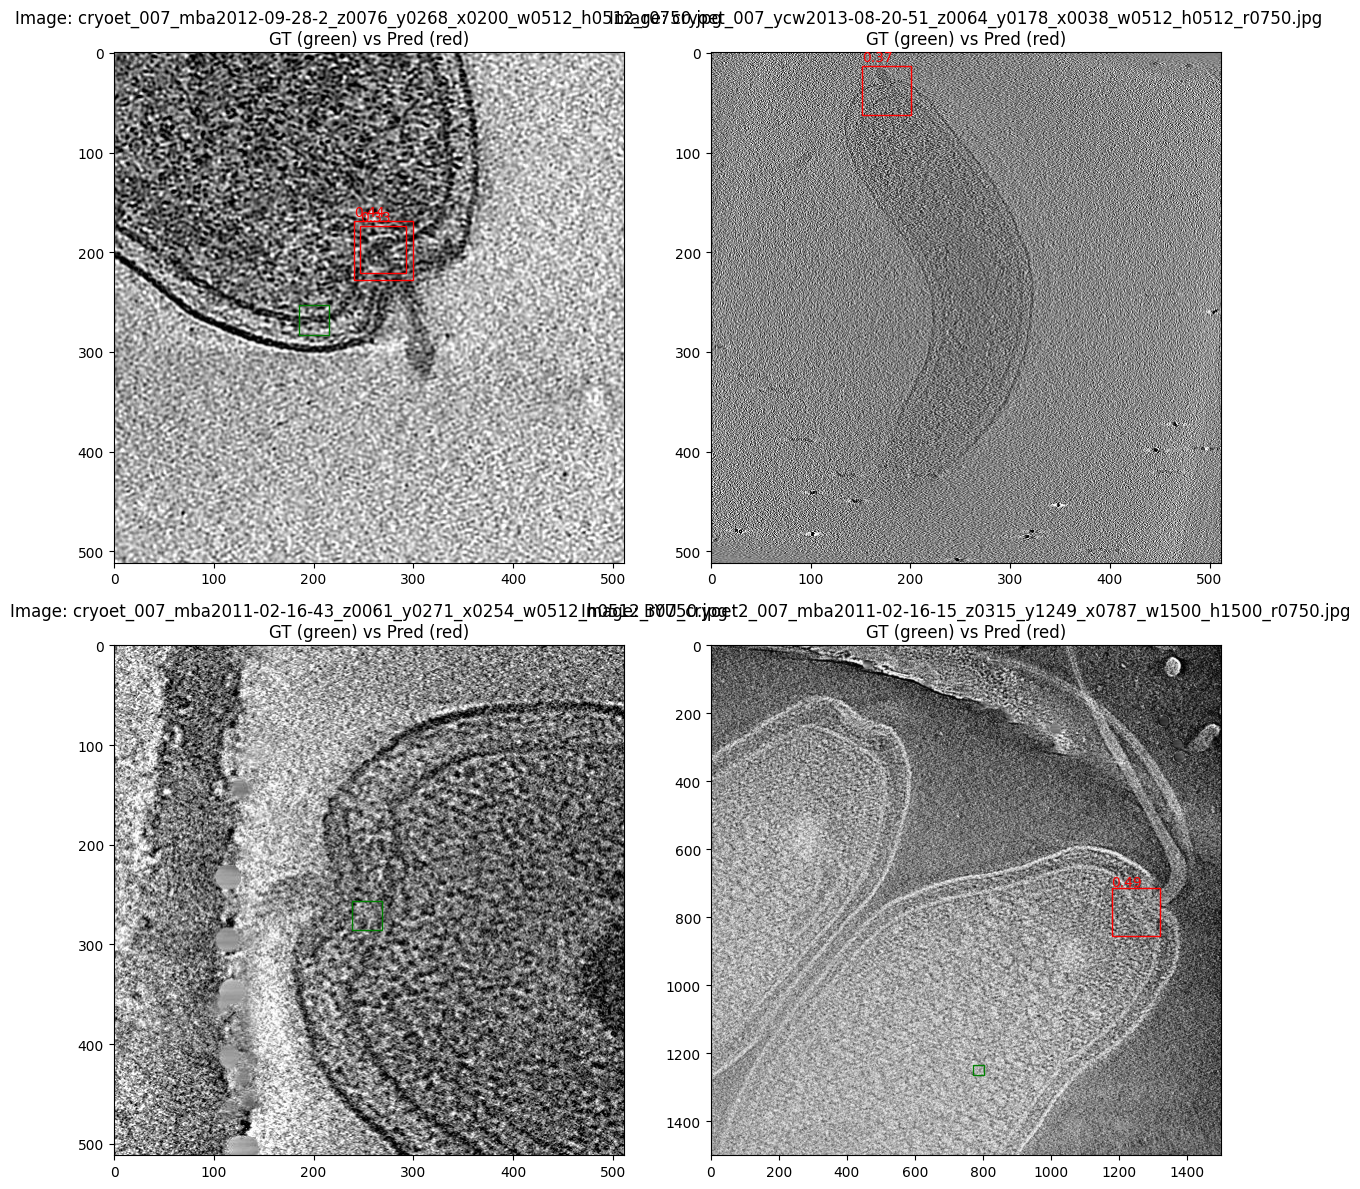

In [33]:
predict_on_samples(model, val_images_dir, num_samples=4, conf = 0.1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

_image = os.path.join(yolo_dataset_dir, "images/shared/val/BYU_tomo_10c564_z0012_y0455_x0267_w0928_h0960_r0980.jpg")
results = model(_image)

model.info()
# Print GPU memory used by this model
allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
print(f"Allocated GPU memory: {allocated:.2f} MB")
print(f"Reserved GPU memory: {reserved:.2f} MB")

NameError: name 'model' is not defined

#### Load Model into DB ####

In [ ]:
import os
import json
import optuna
from optuna.trial import TrialState, FrozenTrial, TrialSystemAttributes
from optuna.storages import RDBStorage
from datetime import datetime

def load_trials_from_dir(yolo_weights_dir):
    trials = []
    for name in os.listdir(yolo_weights_dir):
        if name.startswith("motor_detector_optuma_trial_"):
            folder = os.path.join(yolo_weights_dir, name)
            try:
                with open(os.path.join(folder, "params.json")) as f:
                    params = json.load(f)
                with open(os.path.join(folder, "metrics.json")) as f:
                    value = json.load(f)["loss"]  # or your actual key

                trial = FrozenTrial(
                    number=-1,  # will be set by the storage
                    state=TrialState.COMPLETE,
                    value=value,
                    datetime_start=datetime.now(),
                    datetime_complete=datetime.now(),
                    params=params,
                    distributions={k: optuna.distributions.FloatDistribution(low=0, high=1) for k in params},  # replace with actual dists
                    user_attrs={},
                    system_attrs={},
                    intermediate_values={},
                    trial_id=0,
                )
                trials.append(trial)
            except Exception as e:
                print(f"Skipping {name} due to error: {e}")
    return trials

def insert_trials_to_db(trials, db_path):
    study = optuna.create_study(
        study_name="yolo_hpo",
        storage=db_path,
        direction="minimize",
        load_if_exists=True,
    )
    for trial in trials:
        study.add_trial(trial)

# --- Run this
yolo_weights_dir = os.path.join(local_dev, 'yolo_weights')
db_path = "sqlite:///yolo_hpo.db"

parsed_trials = load_trials_from_dir(yolo_weights_dir)
insert_trials_to_db(parsed_trials, db_path)


### Eval: Display Metrics ###

In [12]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

def display_metrics(metrics_name='motor_detector_BYU_optuna_trial_24', rows=3):
    def show_yolo_gallery(image_paths, rows=rows):
        total = len(image_paths)
        cols = math.ceil(total / rows)
        
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 6 * rows))
        axes = axes.flatten() if total > 1 else [axes]

        for i, ax in enumerate(axes):
            if i < total:
                img = Image.open(image_paths[i])
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(os.path.basename(image_paths[i]), fontsize=8)
            else:
                ax.axis("off")  # Hide empty subplot
        
        plt.tight_layout()
        plt.show()

    # Folder where your YOLO outputs are (update as needed)
    image_dir = os.path.join(yolo_weights_dir, metrics_name)

    # Get all .jpg and .png files
    image_files = sorted(
        # glob.glob(os.path.join(image_dir, "*.jpg")) +
        glob.glob(os.path.join(image_dir, "*.png"))
    )

    # Display all in one row
    show_yolo_gallery(image_files, rows)



motor_detector_shared_optuna_trial_12


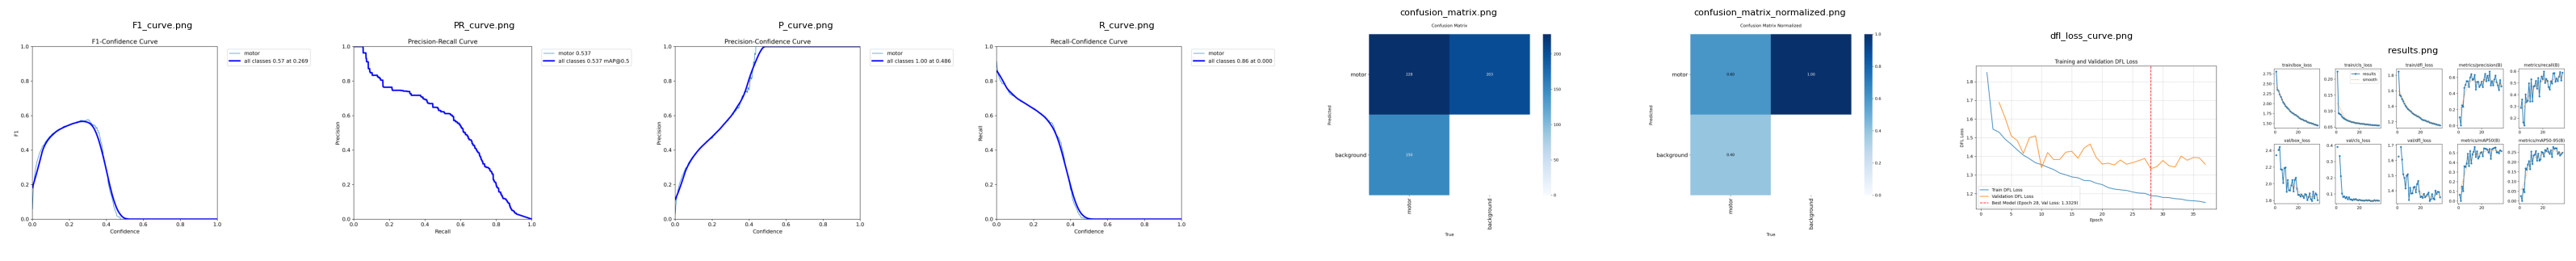

motor_detector_shared_optuna_trial_13


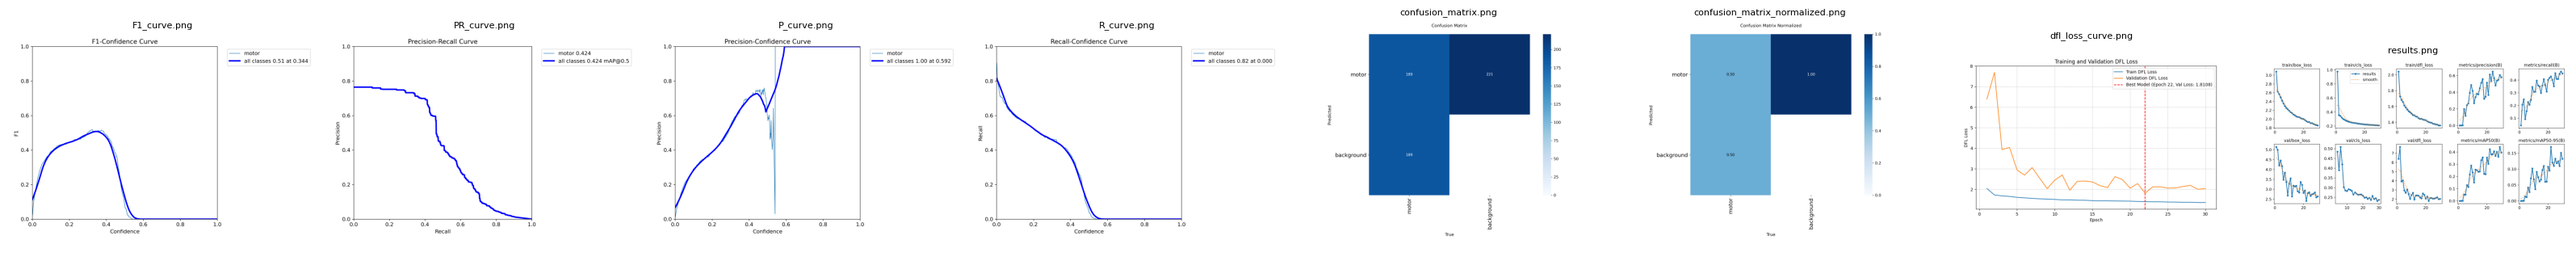

motor_detector_shared_optuna_trial_14


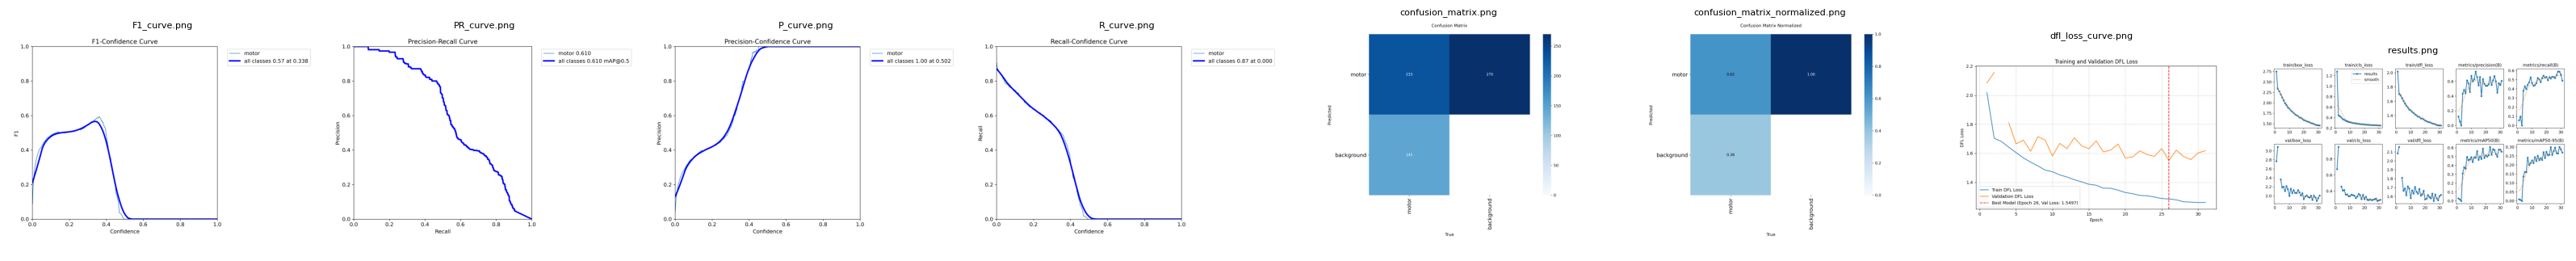

motor_detector_shared_optuna_trial_15


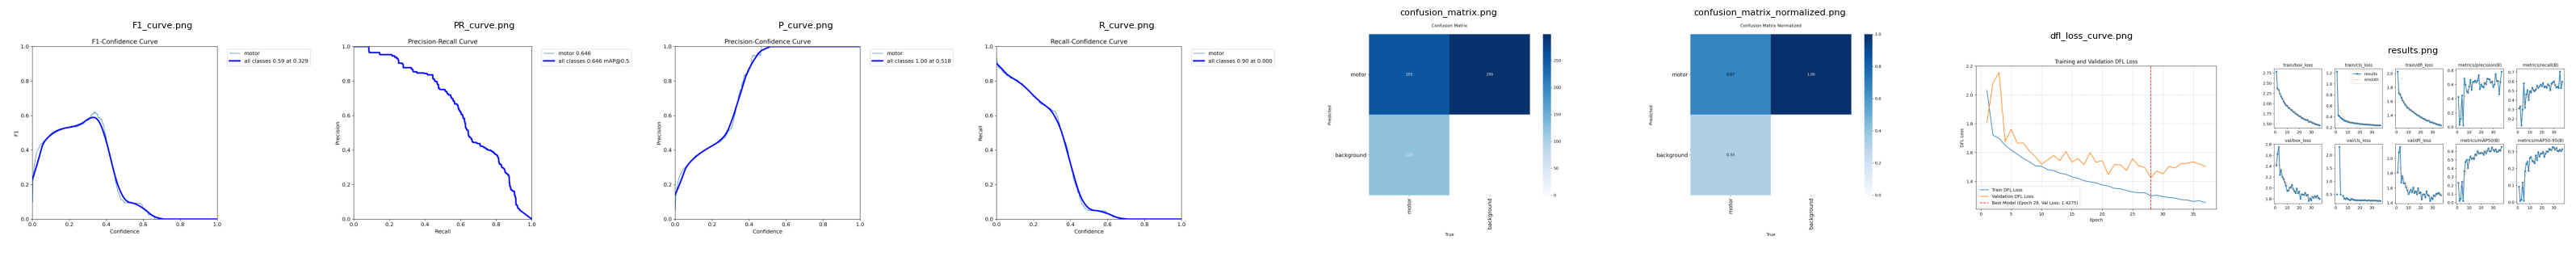

motor_detector_shared_optuna_trial_16


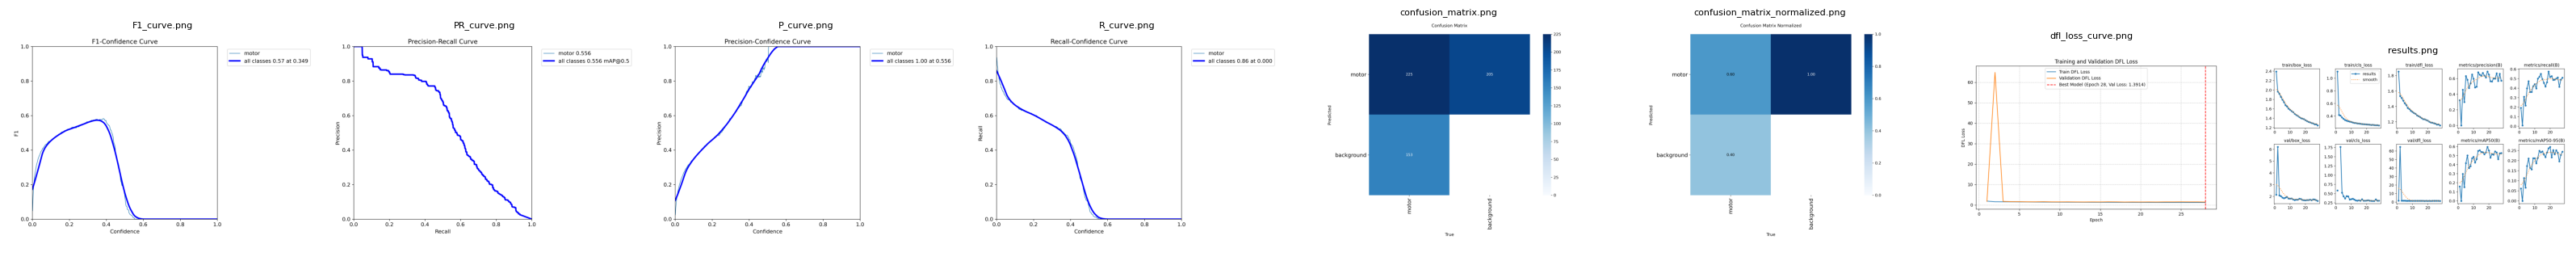

motor_detector_shared_optuna_trial_17


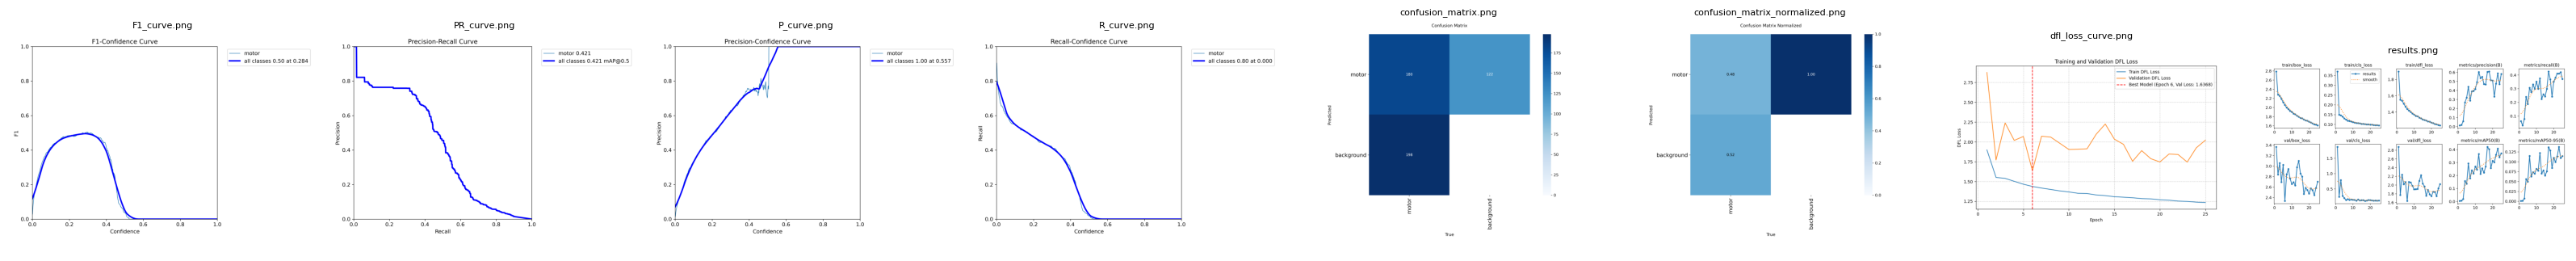

motor_detector_shared_optuna_trial_18


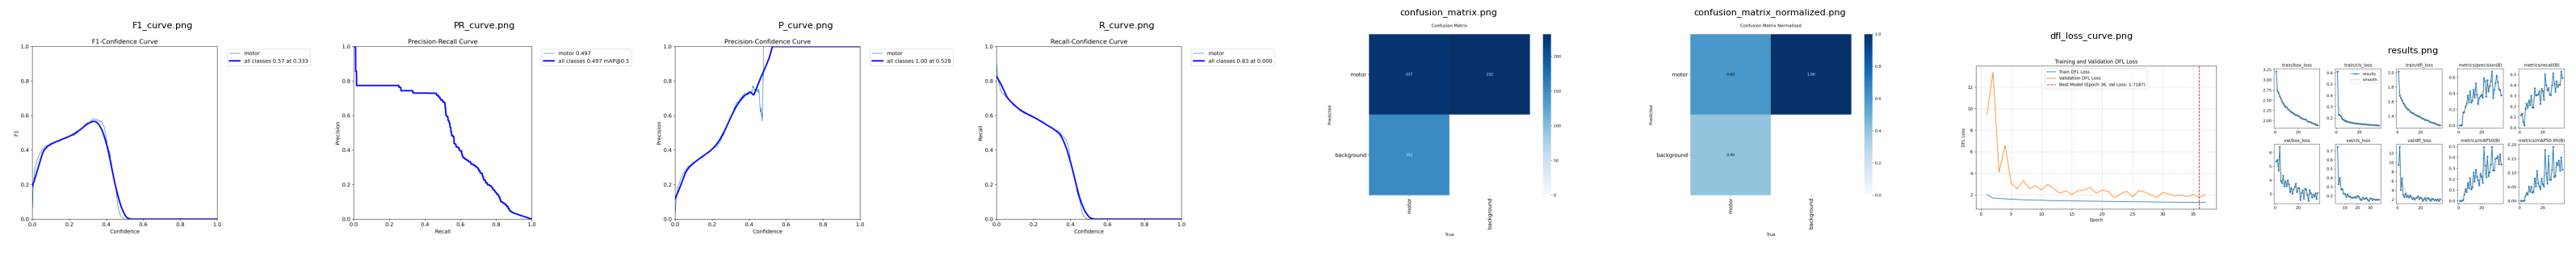

In [13]:
for i in range(12, 19):
    metrics_name=f'motor_detector_shared_optuna_trial_{str(i)}'
    print(metrics_name)
    display_metrics(metrics_name, rows=1)

In [ ]:
import os
import json

yolo_json = {
    "settings_version": "0.0.6",
    "datasets_dir": "/kaggle/working/yolo_dataset",
    "weights_dir": "weights",
    "runs_dir": "runs",
    
    "sync": True,
    "api_key": "",
    "openai_api_key": "",
    "clearml": True,
    "comet": True,
    "dvc": True,
    "hub": True,
    "mlflow": True,
    "neptune": True,
    "raytune": True,
    "tensorboard": False,
    "wandb": True,
    "vscode_msg": True
}

# Write to current user's Ultralytics config directory
os.makedirs(os.path.expanduser("~/.config/Ultralytics"), exist_ok=True)

settings_path = os.path.expanduser("~/.config/Ultralytics/settings.json")
with open(settings_path, 'w') as f:
    json.dump(yolo_json, f, indent=2)

print(f"✅ YOLO settings updated: {settings_path}")

In [ ]:
yaml_content = {
    'path': '.',
    'train': 'images/train',
    'val': 'images/val',
    'names': {0: 'motor'}
}

with open(os.path.join('./yolo_dataset/', 'dataset.yaml'), 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)


# 4) YOLOv8 Inference & Submission Pipeline

This section implements an optimized inference pipeline for generating submissions.

**Overview:**
- **Offline Execution:** The notebook is designed to run offline using a local copy of the Ultralytics YOLOv8 package.
- **Model Loading:** Loads the best trained YOLOv8 weights.
- **GPU Optimization:** Configures CUDA optimizations, half-precision inference, and dynamic batch sizing.
- **Parallel Processing:** Uses CUDA streams and preloading to speed up processing.
- **3D Detection:** Processes each tomographic slice and applies 3D Non-Maximum Suppression (NMS).
- **Submission Generation:** Creates a final CSV with predicted motor coordinates.

## 4.1) Setting Up Inference Libraries

We import additional libraries and set up some GPU and batch parameters for efficient inference.

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define paths for the test data and submission
data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
test_dir = os.path.join(data_path, "test")
submission_path = "/kaggle/working/submission.csv"

# Path to the best trained model (adjust if necessary)
model_path = "/kaggle/working/yolo_weights/motor_detector/weights/best.pt"

# Define detection and processing parameters
CONFIDENCE_THRESHOLD = 0.45
MAX_DETECTIONS_PER_TOMO = 3
NMS_IOU_THRESHOLD = 0.2
CONCENTRATION = 1  # Process a fraction of slices for fast submission

# GPU profiling context manager for timing
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None
        
    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self
        
    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

# Set device and dynamic batch size
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
if device.startswith('cuda'):
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4

## 4.2) Helper Functions for Inference

The functions below handle image normalization, preloading batches, processing each tomogram (with 3D NMS), and debugging image loading.

In [ ]:
def normalize_slice(slice_data):
    """
    Normalize slice data using the 2nd and 98th percentiles.
    """
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory."""
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path))
        images.append(img)
    return images

def perform_3d_nms(detections, iou_threshold):
    """
    Perform 3D Non-Maximum Suppression on detections to merge nearby motors.
    "Consider two detections to be too close if their center-to-center distance is less than BOX_SIZE * iou_threshold."
    ☕ Your Example: Coffee with Two Boxes
        Detection A: confidence 0.8

        Detection B: confidence 0.3

        Both boxes are spatially close (likely centered within the same object)
        Imagine an image with 3 motors, and the detector finds:

            Motor A: 2 overlapping boxes (conf 0.9, 0.5)

            Motor B: 1 box (conf 0.85)

            Motor C: 3 overlapping boxes (conf 0.8, 0.6, 0.3)
    """
    if not detections:
        return []
    
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    final_detections = []
    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + (d1['y'] - d2['y'])**2 + (d1['x'] - d2['x'])**2)
    
    local_box_size = BOX_SIZE
    distance_threshold = BOX_SIZE * iou_threshold
    
    while detections:
        best_detection = detections.pop(0)
        final_detections.append(best_detection)
        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold] #not too close
    
    return final_detections

def process_tomogram(tomo_id, model, index=0, total=1):
    """
    Process a single tomogram and return the most confident motor detection.
    """
    print(f"Processing tomogram {tomo_id} ({index}/{total})")
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    #np.linspace(0, 9, 5) => array([0., 2.25, 4.5, 6.75, 9.])
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CONCENTRATION))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]
    
    print(f"Processing {len(slice_files)} out of {len(os.listdir(tomo_dir))} slices (CONCENTRATION={CONCENTRATION})")
    all_detections = []
    
    if device.startswith('cuda'):
        streams = [torch.cuda.Stream() for _ in range(min(4, BATCH_SIZE))] #batch stream
    else:
        streams = [None]
    
    next_batch_thread = None
    next_batch_images = None
    
    for batch_start in range(0, len(slice_files), BATCH_SIZE): # batch of sclies
        if next_batch_thread is not None:
            next_batch_thread.join()  #allow multiple thread process different batch
            next_batch_images = None
            
        batch_end = min(batch_start + BATCH_SIZE, len(slice_files))
        batch_files = slice_files[batch_start:batch_end]
        
        next_batch_start = batch_end
        next_batch_end = min(next_batch_start + BATCH_SIZE, len(slice_files))
        next_batch_files = slice_files[next_batch_start:next_batch_end] if next_batch_start < len(slice_files) else []
        if next_batch_files:
            next_batch_paths = [os.path.join(tomo_dir, f) for f in next_batch_files]
            next_batch_thread = threading.Thread(target=preload_image_batch, args=(next_batch_paths,))
            next_batch_thread.start()
        else:
            next_batch_thread = None
        
        sub_batches = np.array_split(batch_files, len(streams))
        for i, sub_batch in enumerate(sub_batches):
            if len(sub_batch) == 0:
                continue
            stream = streams[i % len(streams)]
            with torch.cuda.stream(stream) if stream and device.startswith('cuda') else nullcontext():
                sub_batch_paths = [os.path.join(tomo_dir, slice_file) for slice_file in sub_batch]
                sub_batch_slice_nums = [int(slice_file.split('_')[1].split('.')[0]) for slice_file in sub_batch]
                with GPUProfiler(f"Inference batch {i+1}/{len(sub_batches)}"):
                    sub_results = model(sub_batch_paths, verbose=False)
                for j, result in enumerate(sub_results):
                    if len(result.boxes) > 0:
                        for box_idx, confidence in enumerate(result.boxes.conf):
                            if confidence >= CONFIDENCE_THRESHOLD:
                                x1, y1, x2, y2 = result.boxes.xyxy[box_idx].cpu().numpy()
                                x_center = (x1 + x2) / 2
                                y_center = (y1 + y2) / 2
                                all_detections.append({
                                    'z': round(sub_batch_slice_nums[j]),
                                    'y': round(y_center),
                                    'x': round(x_center),
                                    'confidence': float(confidence)
                                })
        if device.startswith('cuda'):
            torch.cuda.synchronize()
    
    if next_batch_thread is not None:
        next_batch_thread.join()
    
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD)
    final_detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    if not final_detections:
        return {'tomo_id': tomo_id, 'Motor axis 0': -1, 'Motor axis 1': -1, 'Motor axis 2': -1}
    
    best_detection = final_detections[0]
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }

def debug_image_loading(tomo_id):
    """
    Debug function to test image loading methods.
    """
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    if not slice_files:
        print(f"No image files found in {tomo_dir}")
        return
        
    print(f"Found {len(slice_files)} image files in {tomo_dir}")
    sample_file = slice_files[len(slice_files)//2]
    img_path = os.path.join(tomo_dir, sample_file)
    
    try:
        img_pil = Image.open(img_path)
        print(f"PIL Image shape: {np.array(img_pil).shape}, dtype: {np.array(img_pil).dtype}")
        img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"OpenCV Image shape: {img_cv2.shape}, dtype: {img_cv2.dtype}")
        img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        print(f"OpenCV RGB Image shape: {img_rgb.shape}, dtype: {img_rgb.dtype}")
        print("Image loading successful!")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        
    try:
        test_model = YOLO(model_path)
        test_results = test_model([img_path], verbose=False)
        print("YOLO model successfully processed the test image")
    except Exception as e:
        print(f"Error with YOLO processing: {e}")

In [ ]:
def generate_submission():
    """
    Main function to generate the submission file.
    """
    test_tomos = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    total_tomos = len(test_tomos)
    print(f"Found {total_tomos} tomograms in test directory")
    
    if test_tomos:
        debug_image_loading(test_tomos[0])
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Loading YOLO model from {model_path}")
    model = YOLO(model_path)
    model.to(device)
    if device.startswith('cuda'):
        model.fuse()
        if torch.cuda.get_device_capability(0)[0] >= 7:
            model.model.half()
            print("Using half precision (FP16) for inference")
    
    results = []
    motors_found = 0
    
    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_tomo = {}
        for i, tomo_id in enumerate(test_tomos, 1):
            future = executor.submit(process_tomogram, tomo_id, model, i, total_tomos)
            future_to_tomo[future] = tomo_id
        
        for future in future_to_tomo:
            tomo_id = future_to_tomo[future]
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                result = future.result()
                results.append(result)
                has_motor = not pd.isna(result['Motor axis 0'])
                if has_motor:
                    motors_found += 1
                    print(f"Motor found in {tomo_id} at position: z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
                else:
                    print(f"No motor detected in {tomo_id}")
                print(f"Current detection rate: {motors_found}/{len(results)} ({motors_found/len(results)*100:.1f}%)")
            except Exception as e:
                print(f"Error processing {tomo_id}: {e}")
                results.append({'tomo_id': tomo_id, 'Motor axis 0': -1, 'Motor axis 1': -1, 'Motor axis 2': -1})
    
    submission_df = pd.DataFrame(results)
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    submission_df.to_csv(submission_path, index=False)
    
    print(f"\nSubmission complete!")
    print(f"Motors detected: {motors_found}/{total_tomos} ({motors_found/total_tomos*100:.1f}%)")
    print(f"Submission saved to: {submission_path}")
    print("\nSubmission preview:")
    print(submission_df.head())
    return submission_df

## 4.4) Run the Submission Pipeline

Finally, we time the entire inference process and generate the submission file.

In [ ]:
if __name__ == "__main__":
    start_time = time.time()
    submission = generate_submission()
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

In [ ]:
import shutil
shutil.make_archive("{output_location}/motor_detector_output", "zip", "{output_location}/yolo_weights/motor_detector")

In [ ]:

import optuna
study = optuna.create_study(
    study_name="shared_007",
    storage="sqlite:///shared_007.db",
    direction="minimize",
    load_if_exists=True,
)
study

[I 2025-05-23 03:18:26,397] Using an existing study with name 'yolo_hpo' instead of creating a new one.


In [ ]:
for i in study.trials:
    print(i.number, i.params,i.duration,i.state)

In [6]:
import os
os.path.abspath("yolo_hpo.db")

'c:\\Users\\Freedomkwok2022\\ML_Learn\\BYU\\notebooks\\yolo_hpo.db'